# Get Started

This package consists of not only the translations, but also with the integration of running the circuit and interpreting the results. They are divided into three main parts: **1) Interpreter, 2) Frontend and 3) Backend**.

To get started with our package, you can use the **Interpreter**, which acts as the hub of everything, in order they are translating the circuit, running the translated circuit and interpret the results. The simplest way is to pass in a gate-based circuit in Qiskit. I are going to use a small example here: the Bell state.


In [1]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)

qc.draw()

┌───┐     
q_0: ┤ H ├──■──
     └───┘┌─┴─┐
q_1: ─────┤ X ├
          └───┘

We can check the actual results after running it with an AerSimulator, it is also provied in the context of an interpreter: GateBasedInterpreter.

To use any interpreter, you will need to create an instance first, and with possible options or parameters. In the gate-based case, nothing needs to be passed. Then you can pass in the qiskit quantum circuit into the run(\*) method to get the results in the type of dictionary. Lastly, you can plot it using qiskit's visualization module.


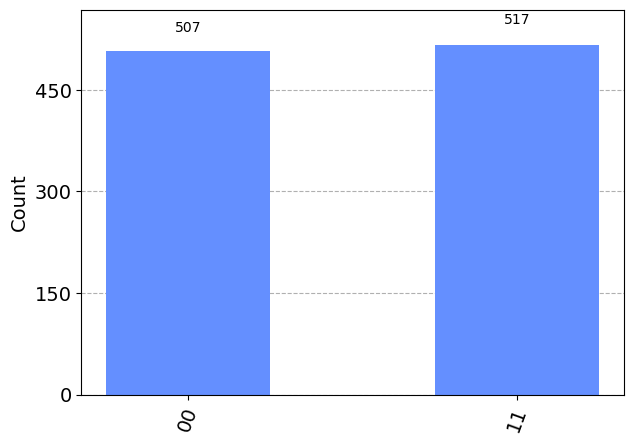

In [2]:
from qiskit.visualization import plot_histogram
from interpreter.gate import GateBasedInterpreter

plot_histogram(GateBasedInterpreter().run(qc))

## 5- and 3-local clock translation (fully working)

The 1st translation comes from Abrahnov et al's paper under Section 3. This translation links each unitary gate with a corresponding clock qubit so it can propagate the gates correctly in the Hamiltonian. The actual results will be paired with the final clock state, which is another layer of a possibility.

There are a few parameters in this Interpreter (ordered):

1. locality: it specifies the type of this translation, in general, 3-local can achieve a more stable results, but with a higher computational cost.

2. transpile_to_two: the circuit should be translpiled to 2- or 1-qubit gates only to satsify the 5- or 3-local translation. But during our test, using any-qubit gates can still achieve the actual results.

3. info: printing out extra information about the translation

4. end_i: it is a technique mentioned in the paper, by adding some identity gates at the end, the possibility of the final clock states may increase.

5. compress: it is a technique that I attempt to improve the translation.


/opt/miniconda3/envs/ac/lib/python3.10/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])



*** INFO ***

locality mode = 5
compress mode = no
qubit map = None
# of gates = 2
# of computation qubits (n) = 2
# of clock qubits (L) = 2
# of ending identities = 0

*** END OF INFO ***



100%|██████████| 4/4 [00:00<00:00, 190.79it/s]


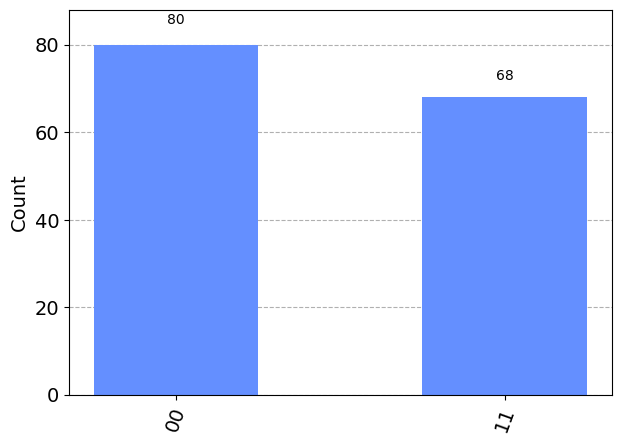

In [3]:
from interpreter.clock import ClockInterpreter

# the default locality is 5
plot_histogram(ClockInterpreter().run(qc))

## 2-local planar clock translation (not working)

The 2nd translation still comes from Abrahnov et al's paper, which is under Section 4. It is a 2-local translation, which means it is the most applicable on real adiabatic hardwares. But it requires a specific layout of the input circuit, which drastically increase the usage of clock qubits. Consequently, the run() of this interpreter is adjusted to a list of gate methods, which is assumed to be the pattern described in the paper.

Note that this translation never produce a satisfying results. Here are two main chanlleges:

1. This translation is no more at a continous line of qubits, the qubits are aligned in a planar grid, which increase the difficulty of the implementation of the Hamiltonian.

2. The qubit used in this translation is a 6-state particle, where my workaround is to use a 3-qubit system to simulate that, which furtherly increase the qubit usages and also effect the actual locality.


In [4]:
from interpreter.planar_clock import PlanarClockInterpreter
from qiskit.circuit.library.standard_gates import *

# Not working
# don't include the ending identity gates for each round
# but if it is an identity gate in the propgation, then include it
# PlanarClockInterpreter().run([[HGate, CXGate]])

## Tensor Network translation (WIP)

I attempted to implement the previous 2-local translation for months, but I can't make any progress. Also, its trade-off on the usage of clock qubits are pretty unacceptable. So I move towards on the a more practical approach in a recently published paper from Anshu et al. Simiarly, their translation utilize the qubits in a grid, but with a different technique: they encode the unitary in a tensor network, and propagate the unitary through gate teleportation.

Note that this is still a work in progress, the input quantum circuit is not converted to be fault-tolerant version in order to fit the translation. But the front EPR states are in an expected form such that the typical bell state pairs (00 and 11) are the majority of the results.

100%|██████████| 7/7 [00:00<00:00, 130.74it/s]


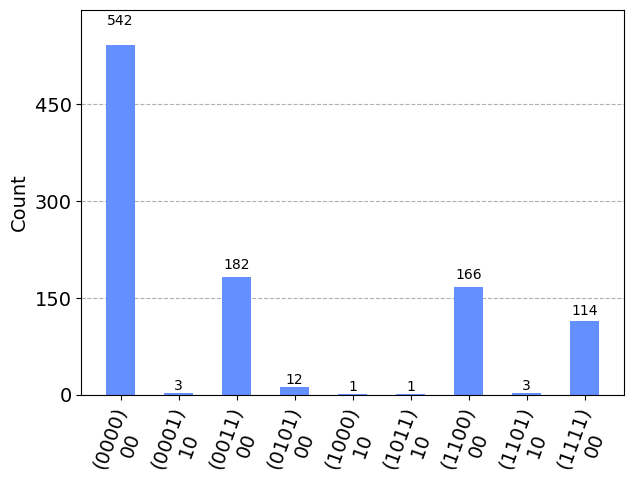

In [6]:
from interpreter.tensor import TensorInterpreter


qc = QuantumCircuit(2)
qc.x(0)
plot_histogram(TensorInterpreter().run(qc, all_histories=True))